In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = None
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the COCO dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

# Image Captioning with Transformers
You have now implemented a vanilla RNN and for the task of image captioning. In this notebook you will implement key pieces of a transformer decoder to accomplish the same task.

**NOTE:** This notebook will be primarily written in PyTorch rather than NumPy, unlike the RNN notebook. 

In [2]:
# Setup cell.
import time, os, json
import numpy as np
import matplotlib.pyplot as plt

from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.transformer_layers import *
from cs231n.captioning_solver_transformer import CaptioningSolverTransformer
from cs231n.classifiers.transformer import CaptioningTransformer
from cs231n.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from cs231n.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# COCO Dataset
As in the previous notebooks, we will use the COCO dataset for captioning.

In [4]:
# Load COCO data from disk into a dictionary.
data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary.
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

base dir  C:\Users\alexe\Desktop\stanford_CV\assignment3_git\cs231n\datasets/coco_captioning


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'C:\Users\alexe\Desktop\stanford_CV\assignment3_git\cs231n\datasets/coco_captioning\coco2014_captions.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

# Transformer
As you have seen, RNNs are incredibly powerful but often slow to train. Further, RNNs struggle to encode long-range dependencies (though LSTMs are one way of mitigating the issue). In 2017, Vaswani et al introduced the Transformer in their paper ["Attention Is All You Need"](https://arxiv.org/abs/1706.03762) to a) introduce parallelism and b) allow models to learn long-range dependencies. The paper not only led to famous models like BERT and GPT in the natural language processing community, but also an explosion of interest across fields, including vision. While here we introduce the model in the context of image captioning, the idea of attention itself is much more general.



# Transformer: Multi-Headed Attention

### Dot-Product Attention

Recall that attention can be viewed as an operation on a query $q\in\mathbb{R}^d$, a set of value vectors $\{v_1,\dots,v_n\}, v_i\in\mathbb{R}^d$, and a set of key vectors $\{k_1,\dots,k_n\}, k_i \in \mathbb{R}^d$, specified as

\begin{align}
c = \sum_{i=1}^{n} v_i \alpha_i &\alpha_i = \frac{\exp(k_i^\top q)}{\sum_{j=1}^{n} \exp(k_j^\top q)} \\
\end{align}

where $\alpha_i$ are frequently called the "attention weights", and the output $c\in\mathbb{R}^d$ is a correspondingly weighted average over the value vectors.

### Self-Attention
In Transformers, we perform self-attention, which means that the values, keys and query are derived from the input $X \in \mathbb{R}^{\ell \times d}$, where $\ell$ is our sequence length. Specifically, we learn parameter matrices $V,K,Q \in \mathbb{R}^{d\times d}$ to map our input $X$ as follows:

\begin{align}
v_i = Vx_i\ \ i \in \{1,\dots,\ell\}\\
k_i = Kx_i\ \ i \in \{1,\dots,\ell\}\\
q_i = Qx_i\ \ i \in \{1,\dots,\ell\}
\end{align}

### Multi-Headed Scaled Dot-Product Attention
In the case of multi-headed attention, we learn a parameter matrix for each head, which gives the model more expressivity to attend to different parts of the input. Let $h$ be number of heads, and $Y_i$ be the attention output of head $i$. Thus we learn individual matrices $Q_i$, $K_i$ and $V_i$. To keep our overall computation the same as the single-headed case, we choose $Q_i \in \mathbb{R}^{d\times d/h}$, $K_i \in \mathbb{R}^{d\times d/h}$ and $V_i \in \mathbb{R}^{d\times d/h}$. Adding in a scaling term $\frac{1}{\sqrt{d/h}}$ to our simple dot-product attention above, we have

\begin{equation} \label{qkv_eqn}
Y_i = \text{softmax}\bigg(\frac{(XQ_i)(XK_i)^\top}{\sqrt{d/h}}\bigg)(XV_i)
\end{equation}

where $Y_i\in\mathbb{R}^{\ell \times d/h}$, where $\ell$ is our sequence length.

In our implementation, we then apply dropout here (though in practice it could be used at any step):

$$Y_i = \text{dropout}(Y_i)$$

Finally, then the output of the self-attention is a linear transformation of the concatenation of the heads:

\begin{equation}
Y = [Y_1;\dots;Y_h]A
\end{equation}

were $A \in\mathbb{R}^{d\times d}$ and $[Y_1;\dots;Y_h]\in\mathbb{R}^{\ell \times d}$.

Implement multi-headed scaled dot-product attention in the `MultiHeadAttention` class in the file `cs231n/transformer_layers.py`. The code below will check your implementation. The relative error should be less than 1e-3.

In [325]:
torch.manual_seed(231)

# Choose dimensions such that they are all unique for easier debugging:
# Specifically, the following values correspond to N=1, H=2, T=3, E//H=4, and E=8.
batch_size = 1
sequence_length = 3
embed_dim = 8
attn = MultiHeadAttention(embed_dim, num_heads=2)

# Self-attention.
data = torch.randn(batch_size, sequence_length, embed_dim)
self_attn_output = attn(query=data, key=data, value=data)

# Masked self-attention.
mask = torch.randn(sequence_length, sequence_length) < 0.5
masked_self_attn_output = attn(query=data, key=data, value=data, attn_mask=mask)

# Attention using two inputs.
other_data = torch.randn(batch_size, sequence_length, embed_dim)
attn_output = attn(query=data, key=other_data, value=other_data)

expected_self_attn_output = np.asarray([[
[-0.2494,  0.1396,  0.4323, -0.2411, -0.1547,  0.2329, -0.1936,
          -0.1444],
         [-0.1997,  0.1746,  0.7377, -0.3549, -0.2657,  0.2693, -0.2541,
          -0.2476],
         [-0.0625,  0.1503,  0.7572, -0.3974, -0.1681,  0.2168, -0.2478,
          -0.3038]]])

expected_masked_self_attn_output = np.asarray([[
[-0.1347,  0.1934,  0.8628, -0.4903, -0.2614,  0.2798, -0.2586,
          -0.3019],
         [-0.1013,  0.3111,  0.5783, -0.3248, -0.3842,  0.1482, -0.3628,
          -0.1496],
         [-0.2071,  0.1669,  0.7097, -0.3152, -0.3136,  0.2520, -0.2774,
          -0.2208]]])

expected_attn_output = np.asarray([[
[-0.1980,  0.4083,  0.1968, -0.3477,  0.0321,  0.4258, -0.8972,
          -0.2744],
         [-0.1603,  0.4155,  0.2295, -0.3485, -0.0341,  0.3929, -0.8248,
          -0.2767],
         [-0.0908,  0.4113,  0.3017, -0.3539, -0.1020,  0.3784, -0.7189,
          -0.2912]]])

print('self_attn_output error: ', rel_error(expected_self_attn_output, self_attn_output.detach().numpy()))
print('masked_self_attn_output error: ', rel_error(expected_masked_self_attn_output, masked_self_attn_output.detach().numpy()))
print('attn_output error: ', rel_error(expected_attn_output, attn_output.detach().numpy()))

self_attn_output error:  0.0003772742211599121
masked_self_attn_output error:  0.0001526367643724865
attn_output error:  0.00035224630317522767


In [326]:
torch.manual_seed(231)

# Choose dimensions such that they are all unique for easier debugging:
# Specifically, the following values correspond to N=1, H=2, T=3, E//H=4, and E=8.
batch_size = 1
sequence_length = 3
embed_dim = 8
attn = MultiHeadAttention(embed_dim, num_heads=2)

# data = torch.randn(batch_size, sequence_length, embed_dim)

# Masked self-attention.
# mask = torch.randn(sequence_length, sequence_length) < 0.5
masked_self_attn_output = attn(query=data, key=data, value=data, attn_mask=mask)

In [327]:
masked_self_attn_output

tensor([[[-0.1347,  0.1934,  0.8628, -0.4903, -0.2614,  0.2798, -0.2586,
          -0.3019],
         [-0.0830,  0.2774,  0.7483, -0.3411, -0.5020,  0.1868, -0.3870,
          -0.2400],
         [-0.2071,  0.1669,  0.7097, -0.3152, -0.3136,  0.2520, -0.2774,
          -0.2208]]], grad_fn=<AddBackward0>)

In [366]:
torch.manual_seed(231)

N = attn.N
H = attn.H
D = attn.D
T = attn.T
S = attn.S
E = attn.E

Q = attn.query(data).view(N, T, H, E//H)
K = attn.key(data).view(N, T, H, E//H)
V = attn.value(data).view(N, T, H, E//H)

QK = torch.matmul(Q.permute(0,2,1,3), K.permute(0, 2, 3, 1))/math.sqrt(D//H)
# N, H, S, T
if mask != None:
    QK = QK.masked_fill(mask == 0, -1e9)

attention = attn.softmax(QK)#.permute(0, 2, 1, 3)
attention = attn.dropout(attention)
att_heads = []
for i in range(H):
    att_heads.append(attention[:, i] @ V[:, : , i, :])

y = torch.cat(att_heads, 2)
output  = attn.proj(y)

In [378]:
Q.shape

torch.Size([1, 3, 2, 4])

In [334]:
# reshape embeddings into Heads with view
attn.query(data), attn.key(data)

(tensor([[[ 0.1187,  0.2790, -0.0891, -0.3676,  0.3084, -0.2426, -1.0067,
           -0.6777],
          [ 0.1949, -0.1302, -0.0126,  0.1522, -0.1969, -0.2817, -0.0101,
           -0.2796],
          [ 0.2466,  0.7714,  0.9509,  0.4756, -0.4726, -1.3197, -0.3830,
            0.6767]]], grad_fn=<AddBackward0>),
 tensor([[[ 0.1461, -0.2417,  1.2013, -0.4311,  1.0321,  0.1495, -0.4461,
           -0.5335],
          [-0.1585, -0.0953,  0.1899,  0.1725,  0.1241,  0.1258,  0.0977,
            0.0336],
          [ 1.4716, -0.5412,  0.3583, -0.6764,  0.1506,  1.3902,  0.5700,
            0.7647]]], grad_fn=<AddBackward0>))

In [335]:
# sequence length is 3 and we have 2 elements (heads) in each sequence here -> join those sequence tokens into 1 tensor for the 2 different heads
Q, K

(tensor([[[[ 0.1187,  0.2790, -0.0891, -0.3676],
           [ 0.3084, -0.2426, -1.0067, -0.6777]],
 
          [[ 0.1949, -0.1302, -0.0126,  0.1522],
           [-0.1969, -0.2817, -0.0101, -0.2796]],
 
          [[ 0.2466,  0.7714,  0.9509,  0.4756],
           [-0.4726, -1.3197, -0.3830,  0.6767]]]], grad_fn=<ViewBackward>),
 tensor([[[[ 0.1461, -0.2417,  1.2013, -0.4311],
           [ 1.0321,  0.1495, -0.4461, -0.5335]],
 
          [[-0.1585, -0.0953,  0.1899,  0.1725],
           [ 0.1241,  0.1258,  0.0977,  0.0336]],
 
          [[ 1.4716, -0.5412,  0.3583, -0.6764],
           [ 0.1506,  1.3902,  0.5700,  0.7647]]]], grad_fn=<ViewBackward>))

In [332]:
Q.permute(0,2,1,3), K.permute(0, 2, 3, 1)

(tensor([[[[ 0.1187,  0.2790, -0.0891, -0.3676],
           [ 0.1949, -0.1302, -0.0126,  0.1522],
           [ 0.2466,  0.7714,  0.9509,  0.4756]],
 
          [[ 0.3084, -0.2426, -1.0067, -0.6777],
           [-0.1969, -0.2817, -0.0101, -0.2796],
           [-0.4726, -1.3197, -0.3830,  0.6767]]]], grad_fn=<PermuteBackward>),
 tensor([[[[ 0.1461, -0.1585,  1.4716],
           [-0.2417, -0.0953, -0.5412],
           [ 1.2013,  0.1899,  0.3583],
           [-0.4311,  0.1725, -0.6764]],
 
          [[ 1.0321,  0.1241,  0.1506],
           [ 0.1495,  0.1258,  1.3902],
           [-0.4461,  0.0977,  0.5700],
           [-0.5335,  0.0336,  0.7647]]]], grad_fn=<PermuteBackward>))

In [344]:
# element 0, 1 in QK matrix
Q.permute(0,2,1,3)[0][0, :][0] @ K.permute(0, 2, 3, 1)[0][0, :][:, 1]

tensor(-0.1257, grad_fn=<DotBackward>)

In [333]:
torch.matmul(Q.permute(0,2,1,3), K.permute(0, 2, 3, 1))

tensor([[[[ 1.3392e-03, -1.2574e-01,  2.4045e-01],
          [-2.0832e-02,  5.3731e-03,  2.4983e-01],
          [ 7.8687e-01,  1.5001e-01, -3.5556e-02]],

         [[ 1.0927e+00, -1.1341e-01, -1.3828e+00],
          [-9.1599e-02, -7.0237e-02, -6.4077e-01],
          [-8.7518e-01, -2.3929e-01, -1.6067e+00]]]],
       grad_fn=<UnsafeViewBackward>)

In [367]:
attention

tensor([[[[0.5224, 0.0000, 0.5887],
          [0.5519, 0.5592, 0.0000],
          [0.4649, 0.3381, 0.3081]],

         [[0.8613, 0.0000, 0.2498],
          [0.5526, 0.0000, 0.0000],
          [0.3622, 0.4977, 0.2512]]]], grad_fn=<MulBackward0>)

In [368]:
att_heads

[tensor([[[ 0.4930,  0.3589,  0.3886,  0.2748],
          [ 0.2602,  0.2531, -0.1740,  1.1106],
          [ 0.3433,  0.2756,  0.1826,  0.6208]]], grad_fn=<UnsafeViewBackward>),
 tensor([[[ 0.6456, -0.1818, -1.3483, -1.4386],
          [ 0.3336, -0.1591, -0.8547, -0.7114],
          [ 0.2960, -0.1538, -0.8502, -1.0401]]], grad_fn=<UnsafeViewBackward>)]

In [369]:
V

tensor([[[[ 5.0637e-01,  4.5877e-01, -5.9325e-01,  1.3673e+00],
          [ 6.0367e-01, -2.8798e-01, -1.5468e+00, -1.2874e+00]],

         [[-3.4461e-02, -9.8050e-05,  2.7445e-01,  6.3661e-01],
          [-9.8433e-02, -2.3332e-01, -5.5021e-01, -4.8665e-01]],

         [[ 3.8814e-01,  2.0248e-01,  1.1864e+00, -7.4648e-01],
          [ 5.0297e-01,  2.6523e-01, -6.4246e-02, -1.3200e+00]]]],
       grad_fn=<ViewBackward>)

In [370]:
# reshape to 
V.permute(0, 2, 1, 3)[0][0]

tensor([[ 5.0637e-01,  4.5877e-01, -5.9325e-01,  1.3673e+00],
        [-3.4461e-02, -9.8050e-05,  2.7445e-01,  6.3661e-01],
        [ 3.8814e-01,  2.0248e-01,  1.1864e+00, -7.4648e-01]],
       grad_fn=<SelectBackward>)

In [374]:
#
attention[0] @ V.permute(0, 2, 1, 3)[0][0]

tensor([[[ 0.4930,  0.3589,  0.3886,  0.2748],
         [ 0.2602,  0.2531, -0.1740,  1.1106],
         [ 0.3433,  0.2756,  0.1826,  0.6208]],

        [[ 0.5331,  0.4457, -0.2146,  0.9912],
         [ 0.2798,  0.2535, -0.3278,  0.7555],
         [ 0.2637,  0.2170,  0.2198,  0.6245]]], grad_fn=<UnsafeViewBackward>)

In [352]:
output

tensor([[[-0.1347,  0.1934,  0.8628, -0.4903, -0.2614,  0.2798, -0.2586,
          -0.3019],
         [-0.1013,  0.3111,  0.5783, -0.3249, -0.3842,  0.1482, -0.3628,
          -0.1496],
         [-0.2071,  0.1669,  0.7097, -0.3152, -0.3136,  0.2520, -0.2774,
          -0.2208]]], grad_fn=<AddBackward0>)

# Positional Encoding

While transformers are able to easily attend to any part of their input, the attention mechanism has no concept of token order. However, for many tasks (especially natural language processing), relative token order is very important. To recover this, the authors add a positional encoding to the embeddings of individual word tokens.

Let us define a matrix $P \in \mathbb{R}^{l\times d}$, where $P_{ij} = $

$$
\begin{cases}
\text{sin}\left(i \cdot 10000^{-\frac{j}{d}}\right) & \text{if j is even} \\
\text{cos}\left(i \cdot 10000^{-\frac{(j-1)}{d}}\right) & \text{otherwise} \\
\end{cases}
$$

Rather than directly passing an input $X \in \mathbb{R}^{l\times d}$ to our network, we instead pass $X + P$.

Implement this layer in `PositionalEncoding` in `cs231n/transformer_layers.py`. Once you are done, run the following to perform a simple test of your implementation. You should see errors on the order of `e-3` or less.

In [419]:
torch.manual_seed(231)

batch_size = 1
sequence_length = 2
embed_dim = 6
data = torch.randn(batch_size, sequence_length, embed_dim)

pos_encoder = PositionalEncoding(embed_dim)
output = pos_encoder(data)

expected_pe_output = np.asarray([[[-1.2340,  1.1127,  1.6978, -0.0865, -0.0000,  1.2728],
                                  [ 0.9028, -0.4781,  0.5535,  0.8133,  1.2644,  1.7034]]])

print('pe_output error: ', rel_error(expected_pe_output, output.detach().numpy()))

pe_output error:  0.00010421011374914356


# Inline Question 1

Several key design decisions were made in designing the scaled dot product attention we introduced above. Explain why the following choices were beneficial:
1. Using multiple attention heads as opposed to one.
2. Dividing by $\sqrt{d/h}$ before applying the softmax function. Recall that $d$ is the feature dimension and $h$ is the number of heads.
3. Adding a linear transformation to the output of the attention operation. What would happen if we were to stack attention operations directly?

Only one or two sentences per choice is necessary, but be sure to be specific in addressing what would have happened without each given implementation detail, why such a situation would be suboptimal, and how the proposed implementation improves the situation.

**Your Answer:** 

1) multiple attention heads can help capturing different patterns in teh data. One attention head might look into all the previous words given a word, other to all subjects given a word etc
2) we divide by sqrt(d/h) to standardize the data before applying softmax. Without doing that, we risk to have only few high values, i.e. few elements in each attention vector with high values and all the rest close to zero. 
3) 

# Overfit Transformer Captioning Model on Small Data
Run the following to overfit the Transformer-based captioning model on the same small dataset as we used for the RNN previously.

base dir  C:\Users\KRAVETA\Desktop\stanford\CNN\assignment3\cs231n\datasets/coco_captioning
(Iteration 1 / 200) loss: 5.023862
(Iteration 11 / 200) loss: 2.838942
(Iteration 21 / 200) loss: 1.969234
(Iteration 31 / 200) loss: 1.578227
(Iteration 41 / 200) loss: 1.207432
(Iteration 51 / 200) loss: 1.057128
(Iteration 61 / 200) loss: 0.727914
(Iteration 71 / 200) loss: 0.660021
(Iteration 81 / 200) loss: 0.443527
(Iteration 91 / 200) loss: 0.347747
(Iteration 101 / 200) loss: 0.254522
(Iteration 111 / 200) loss: 0.121431
(Iteration 121 / 200) loss: 0.085655
(Iteration 131 / 200) loss: 0.078406
(Iteration 141 / 200) loss: 0.062939
(Iteration 151 / 200) loss: 0.056023
(Iteration 161 / 200) loss: 0.037782
(Iteration 171 / 200) loss: 0.044153
(Iteration 181 / 200) loss: 0.021118
(Iteration 191 / 200) loss: 0.024430


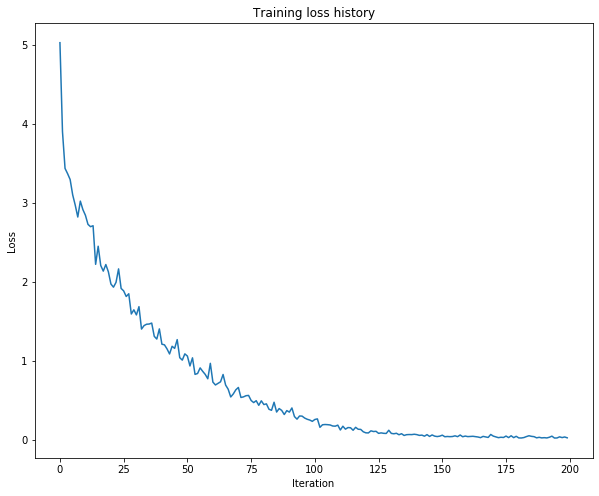

In [421]:
torch.manual_seed(231)
np.random.seed(231)

data = load_coco_data(max_train=50)

transformer = CaptioningTransformer(
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          wordvec_dim=256,
          num_heads=2,
          num_layers=2,
          max_length=30
        )


transformer_solver = CaptioningSolverTransformer(transformer, data, idx_to_word=data['idx_to_word'],
           num_epochs=100,
           batch_size=25,
           learning_rate=0.001,
           verbose=True, print_every=10,
         )

transformer_solver.train()

# Plot the training losses.
plt.plot(transformer_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

Print final training loss. You should see a final loss of less than 0.03.

In [422]:
print('Final loss: ', transformer_solver.loss_history[-1])

Final loss:  0.022452034


# Transformer Sampling at Test Time
The sampling code has been written for you. You can simply run the following to compare with the previous results with the RNN. As before the training results should be much better than the validation set results, given how little data we trained on.

URL Error:  Gone http://farm1.staticflickr.com/202/487987371_489a65d670_z.jpg


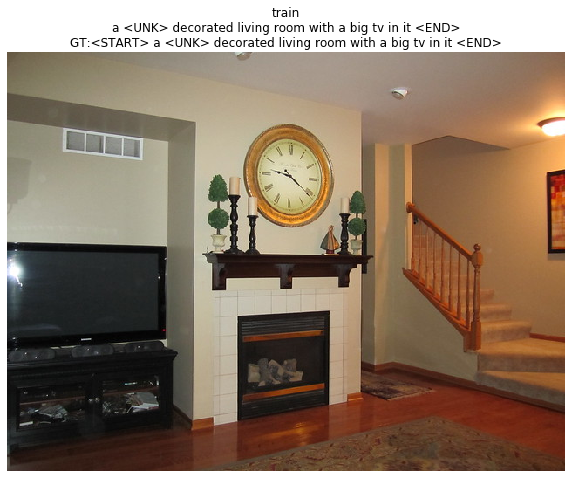

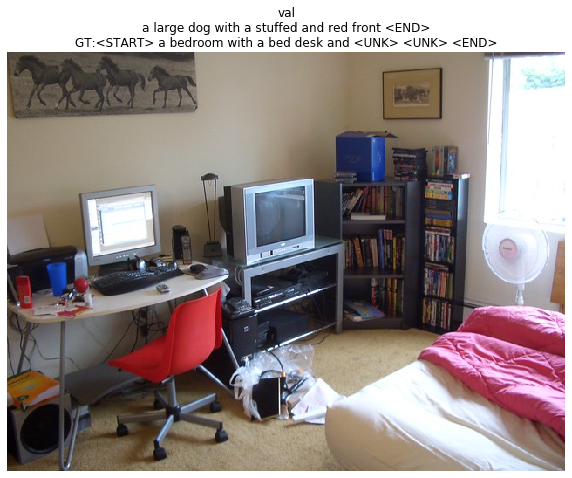

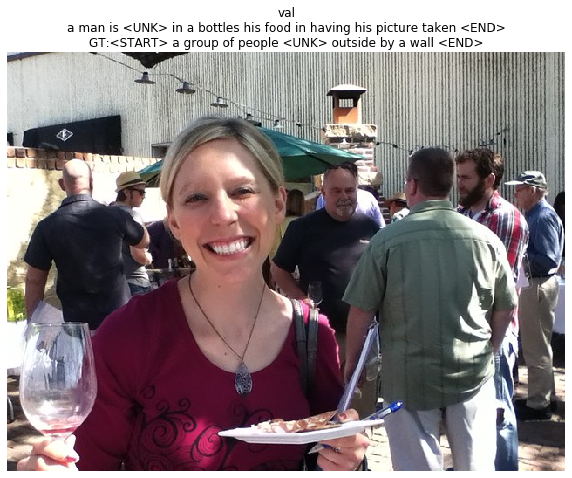

In [423]:
# If you get an error, the URL just no longer exists, so don't worry!
# You can re-sample as many times as you want.
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = transformer.sample(features, max_length=30)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        img = image_from_url(url)
        # Skip missing URLs.
        if img is None: continue
        plt.imshow(img)            
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()